# qPCR analysis of host adaptive and innate immune genes

## Salmo salar mucosal tissue microbiota across functional feed treatments

#### Load libraries

In [1]:
library('dplyr'); packageVersion('dplyr')
library('MCMC.qpcr'); packageVersion('MCMC.qpcr')
library('ggplot2'); packageVersion('ggplot2')
set.seed(123)

Warning message:
“package ‘dplyr’ was built under R version 4.0.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] ‘1.0.7’

Loading required package: MCMCglmm

Warning message:
“package ‘MCMCglmm’ was built under R version 4.0.2”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.0.2”
Loading required package: coda

Warning message:
“package ‘coda’ was built under R version 4.0.2”
Loading required package: ape

Warning message:
“package ‘ape’ was built under R version 4.0.2”
Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.0.2”


[1] ‘1.2.4’

[1] ‘3.3.5’

### Build some custom functions to be used later

In [2]:
remove_geom <- function(ggplot2_object, geom_type) {
  # Delete layers that match the requested type.
  layers <- lapply(ggplot2_object$layers, function(x) {
    if (class(x$geom)[1] == geom_type) {
      NULL
    } else {
      x
    }
  })
  # Delete the unwanted layers.
  layers <- layers[!sapply(layers, is.null)]
  ggplot2_object$layers <- layers
  ggplot2_object
}

In [3]:
pSumFun <- function(pValMatrix) 
{
gene <- colnames(pValMatrix)
gene.pair <- paste(gene[row(pValMatrix)], gene[col(pValMatrix)], sep=" vs ")
i <- lower.tri(pValMatrix)
outputName <- data.frame(gene.pair[i], p.value=pValMatrix[i])
outputName <- filter(outputName, outputName$gene.pair.i. %in% contrastList) # pull out contrast of interest
outputName$BH <- p.adjust(outputName$p.value, method="BH")
outputName <- outputName[order(outputName$BH),] 
} # execute as 'outputName <- pSumFun(pValMatrix)'

In [4]:
pSumFun2 <- function(pValMatrix) 
{
gene <- colnames(pValMatrix)
gene.pair <- paste(gene[row(pValMatrix)], gene[col(pValMatrix)], sep=" vs ")
i <- lower.tri(pValMatrix)
outputName <- data.frame(gene.pair[i], p.value=pValMatrix[i])
outputName <- filter(outputName, outputName$gene.pair.i. %in% contrastList2) # pull out contrast of interest
outputName$BH <- p.adjust(outputName$p.value, method="BH")
outputName <- outputName[order(outputName$BH),] 
} # execute as 'outputName <- pSumFun(pValMatrix)'

#### Read in a custom list of contrasts of interest

In [5]:
contrastList <- as.list(read.csv('Stats/ContrastsOfInterestAdaptive.csv', header=F))$V1
head(contrastList) # a list of contrasts of interest to extract only those values of interest
contrastList2 <- as.list(read.csv('Stats/ContrastsOfInterest.csv', header=F))$V1
head(contrastList2) # a list of contrasts of interest to extract only those values of interest

[1] "TissueGill:DietCocoMOS vs TissueGill:DietCocoOil"
[2] "TissueGill:DietCocoMOS vs TissueGill:DietControl"
[3] "TissueGill:DietCocoMOS vs TissueGill:DietMOS"    
[4] "TissueGill:DietCocoOil vs TissueGill:DietControl"
[5] "TissueGill:DietCocoOil vs TissueGill:DietMOS"    
[6] "TissueGill:DietMOS vs TissueGill:DietControl"

[1] "TissueGill:DietCocoMOS vs TissueGill:DietCocoOil"
[2] "TissueGill:DietCocoMOS vs TissueGill:DietControl"
[3] "TissueGill:DietCocoMOS vs TissueGill:DietMOS"    
[4] "TissueGill:DietCocoOil vs TissueGill:DietControl"
[5] "TissueGill:DietCocoOil vs TissueGill:DietMOS"    
[6] "TissueGill:DietMOS vs TissueGill:DietControl"

#### Load efficiencies and first data set (≈ adaptive)

In [6]:
NCWMAC.eff <- read.csv("mcmcqPCR_effs.csv")
NCWMAC.results <- read.csv("NCWMACqPCR_Adaptive.csv")

In [7]:
levels(NCWMAC.results$Tissue)
levels(NCWMAC.results$Diet)

NULL

NULL

In [8]:
NCWMAC.results$Tissue <- factor(NCWMAC.results$Tissue , levels = c("Gut", "Gill", "Skin", "PBL"))
NCWMAC.results$Diet <- factor(NCWMAC.results$Diet , levels = c("Control", "MOS", "CocoOil", "CocoMOS"))

In [9]:
levels(NCWMAC.results$Tissue)
levels(NCWMAC.results$Diet)

[1] "Gut"  "Gill" "Skin" "PBL"

[1] "Control" "MOS"     "CocoOil" "CocoMOS"

In [10]:
head(NCWMAC.results)

,sample,Individual,Tank,Diet,Tissue,EF1a,HPRT1,RPABC2,CD8a,CD4,FOXP3,IgM,IgT,MHC1,MHC2
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.50941,21.95600,23.13333,25.72569,24.42197,30.58630,23.55509,27.35433,15.89365,16.57095
2,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.42801,21.92615,23.01739,25.61657,24.21822,30.33204,23.45481,27.12759,15.63653,16.37608
3,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.55006,22.26392,24.78876,26.14740,26.36350,32.63988,24.78126,23.85837,16.64591,18.29330
4,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.41079,22.34390,24.76378,26.21488,26.33747,32.77990,24.62312,23.89205,16.53541,18.34659
5,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.51326,21.80875,23.91790,26.03697,25.71809,31.65804,21.55204,25.97776,16.23213,18.07932
6,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.43221,21.55769,23.70948,25.89228,25.58822,31.62162,21.45750,25.82536,16.05344,17.96487


## Run MCMC qPCR analysis

### Adaptive immune gene set - includes PBL samples

In [11]:
dd=cq2counts(data=NCWMAC.results, 
             genecols=c(6:15), 
             condcols=c(1:5),
             effic=NCWMAC.eff, 
             Cq1=37)

In [12]:
informed=mcmc.qpcr(fixed="Tissue+Diet+Tissue:Diet",
                   random=c("Tank", "sample"),
                   data=dd,
                   controls=c("EF1a",
                              "HPRT1",
                              "RPABC2"),
                   m.fix=1.2,
                   normalize=TRUE, # soft-normalization to geometric mean
                   burnin=5000, # liability levels off at 5000 iterations
                   thin=20,
                   nitt=45000,
                   pr=T,
                   pl=T)

$PRIOR
$PRIOR$R
$PRIOR$R$V
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    1    0    0    0    0    0    0    0
[2,]    0    1    0    0    0    0    0    0
[3,]    0    0    1    0    0    0    0    0
[4,]    0    0    0    1    0    0    0    0
[5,]    0    0    0    0    1    0    0    0
[6,]    0    0    0    0    0    1    0    0
[7,]    0    0    0    0    0    0    1    0
[8,]    0    0    0    0    0    0    0    1

$PRIOR$R$nu
[1] 7.002


$PRIOR$G
$PRIOR$G$G1
$PRIOR$G$G1$V
[1] 1

$PRIOR$G$G1$nu
[1] 0


$PRIOR$G$G2
$PRIOR$G$G2$V
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    1    0    0    0    0    0    0    0
[2,]    0    1    0    0    0    0    0    0
[3,]    0    0    1    0    0    0    0    0
[4,]    0    0    0    1    0    0    0    0
[5,]    0    0    0    0    1    0    0    0
[6,]    0    0    0    0    0    1    0    0
[7,]    0    0    0    0    0    0    1    0
[8,]    0    0    0    0    0    0    0    1

$PRIOR$G$G2$nu
[1] 0


$PRIOR$G$G3
$PRIOR$G$G3

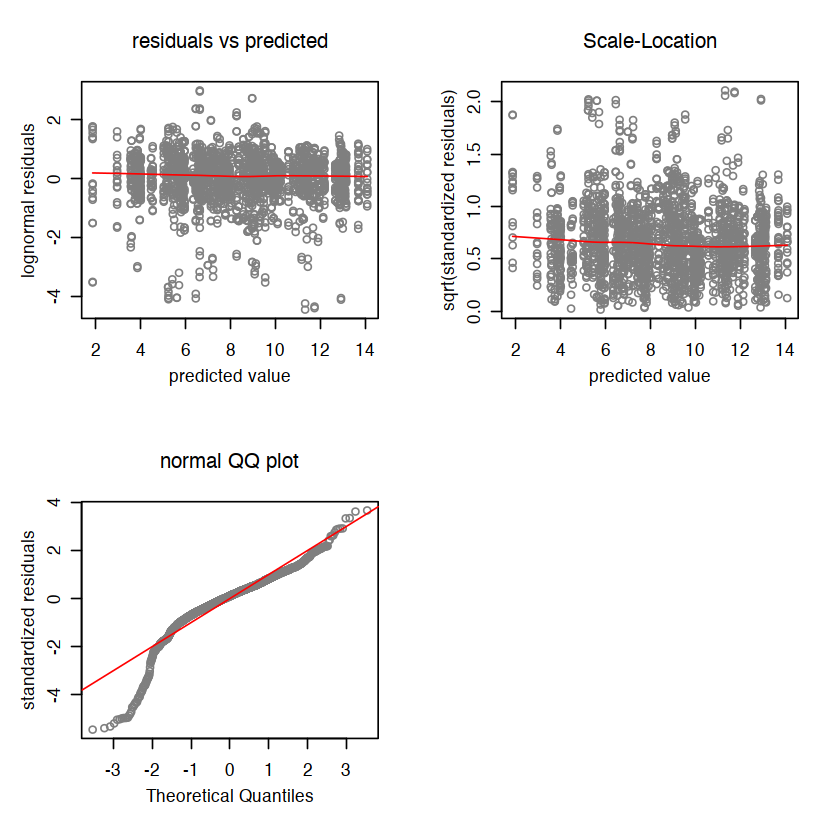

In [13]:
diagnostic.mcmc(model=informed,
                col="grey50", 
                cex=0.8)

#### Remove outliers

In [14]:
outliers <- outlierSamples(informed, dd, z.cutoff = -2)
outliers
ddNoOutliers <- dd[!(dd$sample %in% outliers),]

[1] "Gut_T24_F1"  "PBL_T13_F2"  "Skin_T10_F3" "Skin_T22_F1"

In [15]:
informedNO <- mcmc.qpcr(fixed="Tissue+Diet+Tissue:Diet",
                        random=c("Tank", "sample"),
                        data=ddNoOutliers,
                        controls=c("EF1a",
                                   "HPRT1",
                                   "RPABC2"),
                        m.fix=1.2,
                        normalize=TRUE,
                        burnin=5000, # liability levels off at 5000 iterations
                        thin=20,
                        nitt=45000,
                        pr=T,
                        pl=T)

$PRIOR
$PRIOR$R
$PRIOR$R$V
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    1    0    0    0    0    0    0    0
[2,]    0    1    0    0    0    0    0    0
[3,]    0    0    1    0    0    0    0    0
[4,]    0    0    0    1    0    0    0    0
[5,]    0    0    0    0    1    0    0    0
[6,]    0    0    0    0    0    1    0    0
[7,]    0    0    0    0    0    0    1    0
[8,]    0    0    0    0    0    0    0    1

$PRIOR$R$nu
[1] 7.002


$PRIOR$G
$PRIOR$G$G1
$PRIOR$G$G1$V
[1] 1

$PRIOR$G$G1$nu
[1] 0


$PRIOR$G$G2
$PRIOR$G$G2$V
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    1    0    0    0    0    0    0    0
[2,]    0    1    0    0    0    0    0    0
[3,]    0    0    1    0    0    0    0    0
[4,]    0    0    0    1    0    0    0    0
[5,]    0    0    0    0    1    0    0    0
[6,]    0    0    0    0    0    1    0    0
[7,]    0    0    0    0    0    0    1    0
[8,]    0    0    0    0    0    0    0    1

$PRIOR$G$G2$nu
[1] 0


$PRIOR$G$G3
$PRIOR$G$G3

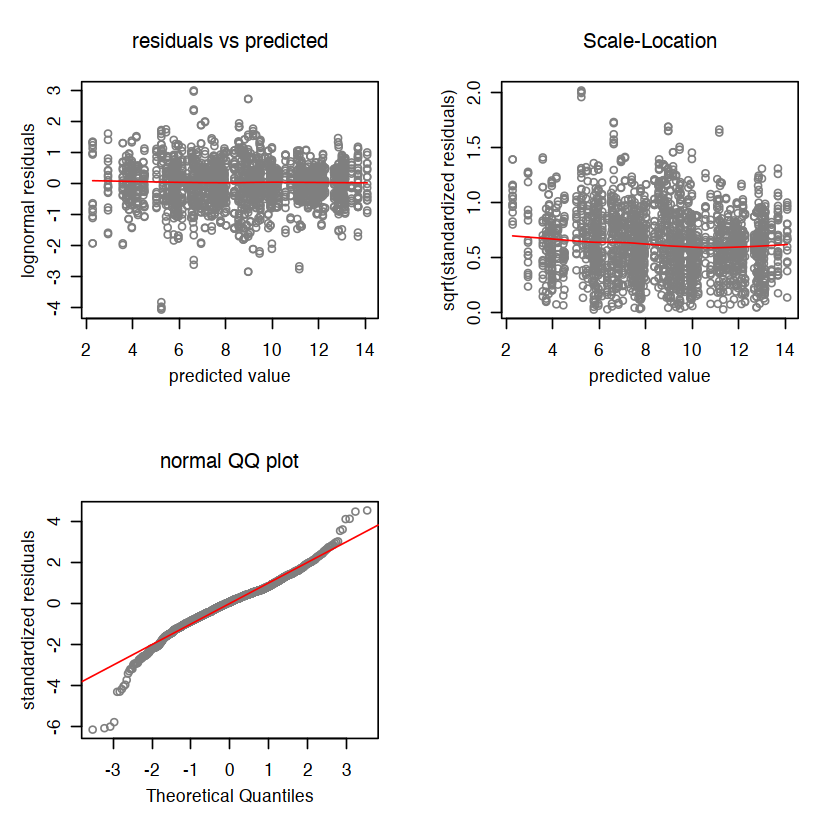

In [16]:
diagnostic.mcmc(model=informedNO,
                col="grey50", 
                cex=0.8)

In [17]:
capture.output(summary(informedNO), file = 'AdaptiveGenes_StatsOutput.csv')

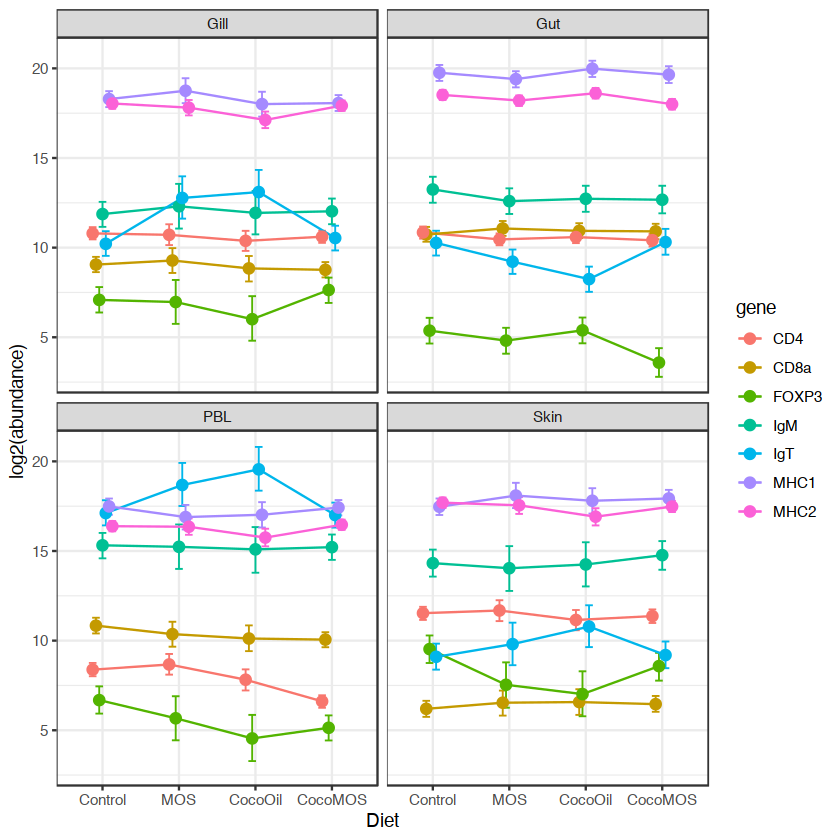

In [18]:
dietOrder <- c('Control', 'MOS', 'CocoOil', 'CocoMOS')
NCWMACsum <- HPDsummary(model=informedNO,
                        ddNoOutliers,
                        relative=F,
                        xgroup = 'Diet',
                        x.order=dietOrder,
                        log.base=2)

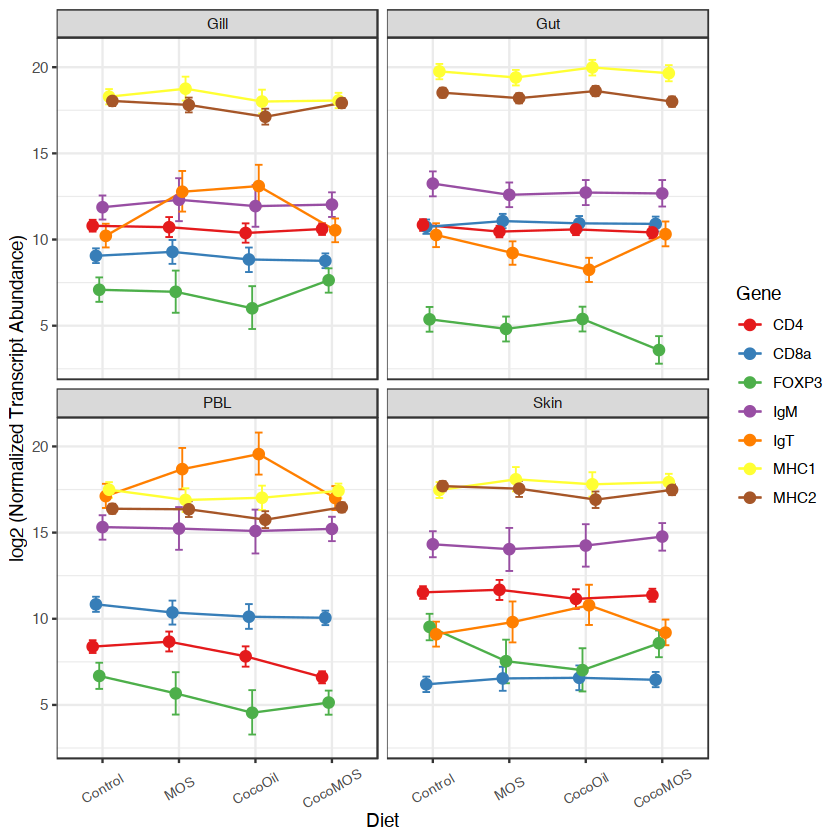

In [19]:
NCWMACsum$ggPlot$labels$colour <- 'Gene'
NCWMACsum$ggPlot + ylab('log2 (Normalized Transcript Abundance)'
                ) + scale_color_brewer(palette = 'Set1'
                                      )+ theme(axis.text.x = element_text(size=8,
                                                                          angle=30,
                                                                          hjust = 0.5,
                                                                          vjust = 0.5))

### Adaptive immune genes Trellis Plot - Normalized Expression

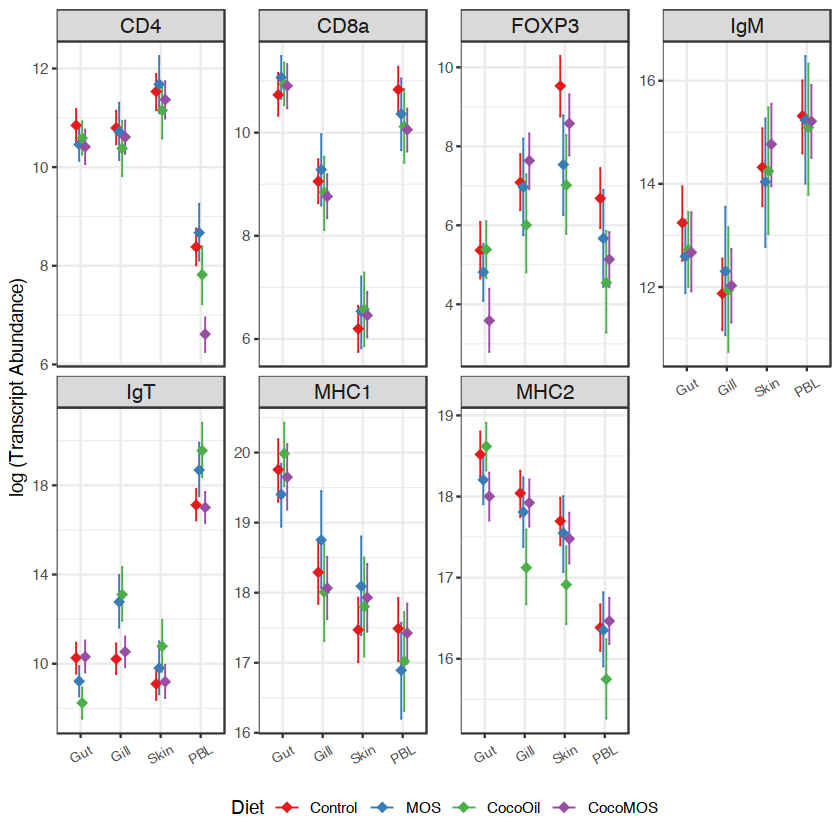

In [20]:
trellPlot <- trellisByGene(NCWMACsum, xFactor="Tissue", groupFactor="Diet")
trellPlot$data$Tissue <- factor(trellPlot$data$Tissue, levels = c("Gut", "Gill", "Skin", "PBL"))
trellPlot$data$Diet <- factor(trellPlot$data$Diet, levels = c("Control", "MOS", "CocoOil", "CocoMOS"))
trellPlotNP <- remove_geom(trellPlot, "GeomPoint")
trellPlotNP <- remove_geom(trellPlotNP, "GeomLine")
trellPlotNP <- trellPlotNP + geom_point(shape=18, size=3, position=position_dodge(width=.3))
trellPlotNP <- trellPlotNP + scale_color_brewer(palette = 'Set1', type='div'
                                                ) + theme(axis.text.x = element_text(size=8,
                                                                                    angle=30,
                                                                                    hjust = 0.5,
                                                                                    vjust = 0.5),
                                                          axis.title.x = element_blank()
                                                         ) + ylab('log (Transcript Abundance)')
trellPlotNP

#### Add significance annotations

In [21]:
dat_text <- data.frame(label = c("",
                                 "----------",
                                 "----------",
                                 "",
                                 "",
                                 "----------",
                                 ""),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(9.7,
                                 9.8,
                                 9,
                                 12,
                                 7,
                                 16.5,
                                 5.75))
dat_text2 <- data.frame(label = c("",
                                  "----------",
                                  "----------",
                                  "----------",
                                  "",
                                  "",
                                  ""),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(6,
                                 7.5,
                                 4,
                                 16,
                                 9.2,
                                 10.6,
                                 4))
dat_text3 <- data.frame(label = c("----------",
                                  "----------",
                                  "----------",
                                  "",
                                  "----------",
                                  "",
                                  "----------"),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(10,
                                 9,
                                 2,
                                 7.5,
                                 15,
                                 10.75,
                                 14))
dat_text4 <- data.frame(label = c("",
                                  "----------------",
                                  "",
                                  "",
                                  "",
                                  "----------------",
                                  "----------------"),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(6,
                                 5,
                                 -2.5,
                                 7.5,
                                 9.5,
                                 15,
                                 12))
dat_text5 <- data.frame(label = c("------------------------",
                                  "",
                                  "",
                                  "------------------------",
                                  "------------------------",
                                  "------------------------",
                                  "------------------------"),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(9.5,
                                 9,
                                 1,
                                 10,
                                 20,
                                 14.5,
                                 11))
dat_text6 <- data.frame(label = c("-----------------",
                                  "-----------------",
                                  "",
                                  "-----------------",
                                  "-----------------",
                                  "",
                                  "-----------------"),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(9.2,
                                 7.2,
                                 2,
                                 9.5,
                                 14.3,
                                 14.3,
                                 10))
dat_text7 <- data.frame(label = c("",
                                  "",
                                  "*",
                                  "",
                                  "*",
                                  "",
                                  ""),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(9.2,
                                 7.2,
                                 7,
                                 9.5,
                                 14,
                                 14.3,
                                 10))
dat_text8 <- data.frame(label = c("",
                                  "",
                                  "",
                                  "",
                                  "*",
                                  "",
                                  "*"),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(9.2,
                                 7.2,
                                 5,
                                 9.5,
                                 14.5,
                                 14.3,
                                 14))
dat_text9 <- data.frame(label = c("",
                                  "",
                                  "*",
                                  "",
                                  "",
                                  "",
                                  ""),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(9.2,
                                 7.2,
                                 2,
                                 9.5,
                                 14.5,
                                 14.3,
                                 14))
dat_text10 <- data.frame(label = c("*",
                                   "",
                                   "",
                                   "",
                                   "*",
                                   "",
                                   ""),
                        Diet = 'Control',
                        gene = c("CD4",
                                 "CD8a",
                                 "FOXP3",
                                 "IgM",
                                 "IgT",
                                 "MHC1",
                                 "MHC2"),
                        yVal = c(11,
                                 7.2,
                                 2.5,
                                 9.5,
                                 12,
                                 14.3,
                                 11))

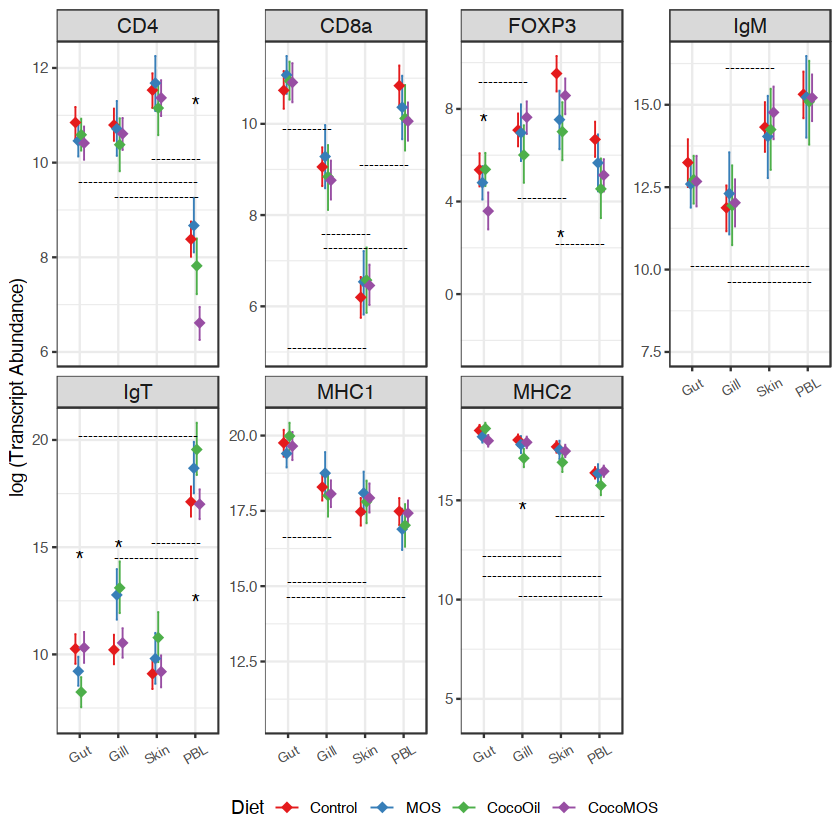

In [22]:
trellPlotNPannot <- trellPlotNP + geom_text(data = dat_text,
                                              mapping = aes(x = 1.5,
                                                            y = yVal,
                                                            label = label),
                                              vjust = 0,
                                              color ='black',
                                              size=3) + geom_text(data = dat_text2,
                                                                  mapping = aes(x = 2.5,
                                                                                y = yVal,
                                                                                label = label),
                                                                  vjust = 0,
                                                                  color ='black',
                                                                  size=3) + geom_text(data = dat_text3,
                                                                                      mapping = aes(x = 3.5,
                                                                                                    y = yVal,
                                                                                                    label = label),
                                                                                      vjust = 0,
                                                                                      color ='black',
                                                                                      size=3) + geom_text(data = dat_text4,
                                                                                                          mapping = aes(x = 2,
                                                                                                                        y = yVal,
                                                                                                                        label = label),
                                                                                                          vjust = 0,
                                                                                                          color ='black',
                                                                                                          size=3) + geom_text(data = dat_text5,
                                                                                                                              mapping = aes(x = 2.5,
                                                                                                                                            y = yVal,
                                                                                                                                            label = label),
                                                                                                                                  vjust = 0,
                                                                                                                                  color ='black',
                                                                                                                                  size=3) + geom_text(data = dat_text6,
                                                                                                                                                      mapping = aes(x = 3,
                                                                                                                                                                    y = yVal,
                                                                                                                                                                    label = label),
                                                                                                                                                          vjust = 0,
                                                                                                                                                          color ='black',
                                                                                                                                                          size=3) + geom_text(data = dat_text7,
                                                                                                                                                                              mapping = aes(x = 1,
                                                                                                                                                                                            y = yVal,
                                                                                                                                                                                            label = label),
                                                                                                                                                                                  vjust = 0,
                                                                                                                                                                                  color ='black',
                                                                                                                                                                                  size=5) + geom_text(data = dat_text8,
                                                                                                                                                                                                      mapping = aes(x = 2,
                                                                                                                                                                                                                    y = yVal,
                                                                                                                                                                                                                    label = label),
                                                                                                                                                                                                          vjust = 0,
                                                                                                                                                                                                          color ='black',
                                                                                                                                                                                                          size=5) + geom_text(data = dat_text9,
                                                                                                                                                                                                                              mapping = aes(x = 3,
                                                                                                                                                                                                                                            y = yVal,
                                                                                                                                                                                                                                            label = label),
                                                                                                                                                                                                                                  vjust = 0,
                                                                                                                                                                                                                                  color ='black',
                                                                                                                                                                                                                                  size=5) + geom_text(data = dat_text10,
                                                                                                                                                                                                                                                      mapping = aes(x = 4,
                                                                                                                                                                                                                                                                    y = yVal,
                                                                                                                                                                                                                                                                    label = label),
                                                                                                                                                                                                                                                          vjust = 0,
                                                                                                                                                                                                                                                          color ='black',
                                                                                                                                                                                                                                                          size=5)
trellPlotNPannot

#### Get gene wise p-values, convert to list, and adjust using BH FDR. pSumFun function defined at beginning of workbook 

In [23]:
cd8a_Padj <- pSumFun(NCWMACsum$geneWise$CD8a)
write.csv(cd8a_Padj, 'Stats/cd8aSigContrasts.csv')
cd4_Padj <- pSumFun(NCWMACsum$geneWise$CD4)
write.csv(cd4_Padj, 'Stats/cd4SigContrasts.csv')
foxp3_Padj <- pSumFun(NCWMACsum$geneWise$FOXP)
write.csv(foxp3_Padj, 'Stats/foxp3SigContrasts.csv')
igm_Padj <- pSumFun(NCWMACsum$geneWise$IgM)
write.csv(igm_Padj, 'Stats/igmSigContrasts.csv')
igt_Padj <- pSumFun(NCWMACsum$geneWise$IgT)
write.csv(igt_Padj, 'Stats/igtSigContrasts.csv')
mhc1_Padj <- pSumFun(NCWMACsum$geneWise$MHC1)
write.csv(mhc1_Padj, 'Stats/mhc1SigContrasts.csv')
mhc2_Padj <- pSumFun(NCWMACsum$geneWise$MHC2)
write.csv(mhc2_Padj, 'Stats/mhc2SigContrasts.csv')

# Analyze Innate Genes - no PBL tissue

In [24]:
NCWMAC.res2 <- read.csv("NCWMACqPCR_Innate.csv")

In [25]:
head(NCWMAC.res2)
levels(NCWMAC.res2$Tissue)
levels(NCWMAC.res2$Diet)

,sample,Individual,Tank,Diet,Tissue,EF1a,HPRT1,RPABC2,ALP,LYZ,C3,MBLc,IL1b,IL10,IL17a,mTLR5
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.50941,21.95600,23.13333,33.41425,23.12679,30.33708,25.93635,31.67191,35.70186,31.34066,32.30171
2,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.42801,21.92615,23.01739,33.29742,22.90966,29.75826,25.57051,31.43789,36.74443,31.07862,33.76428
3,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.55006,22.26392,24.78876,34.75723,24.83281,33.03520,27.37864,33.92473,-1.00000,32.20067,-1.00000
4,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.41079,22.34390,24.76378,34.79094,24.69027,32.36811,27.71374,33.23739,38.11772,32.20785,-1.00000
5,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.51326,21.80875,23.91790,32.67258,23.98461,27.93557,25.23935,31.55069,38.88426,32.62991,30.05337
6,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.43221,21.55769,23.70948,32.53384,23.92002,28.60913,24.98556,31.07396,36.18448,32.88276,NA


NULL

NULL

In [26]:
NCWMAC.res2$Tissue <- factor(NCWMAC.res2$Tissue , levels = c("Gut", "Gill", "Skin"))
NCWMAC.res2$Diet <- factor(NCWMAC.res2$Diet , levels = c("Control", "MOS", "CocoOil", "CocoMOS"))

In [27]:
head(NCWMAC.res2)
levels(NCWMAC.res2$Tissue)
levels(NCWMAC.res2$Diet)

,sample,Individual,Tank,Diet,Tissue,EF1a,HPRT1,RPABC2,ALP,LYZ,C3,MBLc,IL1b,IL10,IL17a,mTLR5
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.50941,21.95600,23.13333,33.41425,23.12679,30.33708,25.93635,31.67191,35.70186,31.34066,32.30171
2,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.42801,21.92615,23.01739,33.29742,22.90966,29.75826,25.57051,31.43789,36.74443,31.07862,33.76428
3,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.55006,22.26392,24.78876,34.75723,24.83281,33.03520,27.37864,33.92473,-1.00000,32.20067,-1.00000
4,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.41079,22.34390,24.76378,34.79094,24.69027,32.36811,27.71374,33.23739,38.11772,32.20785,-1.00000
5,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.51326,21.80875,23.91790,32.67258,23.98461,27.93557,25.23935,31.55069,38.88426,32.62991,30.05337
6,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.43221,21.55769,23.70948,32.53384,23.92002,28.60913,24.98556,31.07396,36.18448,32.88276,NA


[1] "Gut"  "Gill" "Skin"

[1] "Control" "MOS"     "CocoOil" "CocoMOS"

#### MCMCqPCR for innate genes

In [28]:
dd2=cq2counts(data=NCWMAC.res2, 
              genecols=c(6:16),
              condcols=c(1:5),
              effic=NCWMAC.eff, 
              Cq1=37)

$PRIOR
$PRIOR$R
$PRIOR$R$V
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
 [1,]    1    0    0    0    0    0    0    0    0
 [2,]    0    1    0    0    0    0    0    0    0
 [3,]    0    0    1    0    0    0    0    0    0
 [4,]    0    0    0    1    0    0    0    0    0
 [5,]    0    0    0    0    1    0    0    0    0
 [6,]    0    0    0    0    0    1    0    0    0
 [7,]    0    0    0    0    0    0    1    0    0
 [8,]    0    0    0    0    0    0    0    1    0
 [9,]    0    0    0    0    0    0    0    0    1

$PRIOR$R$nu
[1] 8.002


$PRIOR$G
$PRIOR$G$G1
$PRIOR$G$G1$V
[1] 1

$PRIOR$G$G1$nu
[1] 0


$PRIOR$G$G2
$PRIOR$G$G2$V
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
 [1,]    1    0    0    0    0    0    0    0    0
 [2,]    0    1    0    0    0    0    0    0    0
 [3,]    0    0    1    0    0    0    0    0    0
 [4,]    0    0    0    1    0    0    0    0    0
 [5,]    0    0    0    0    1    0    0    0    0
 [6,]    0    0    0    0    0    1    0 

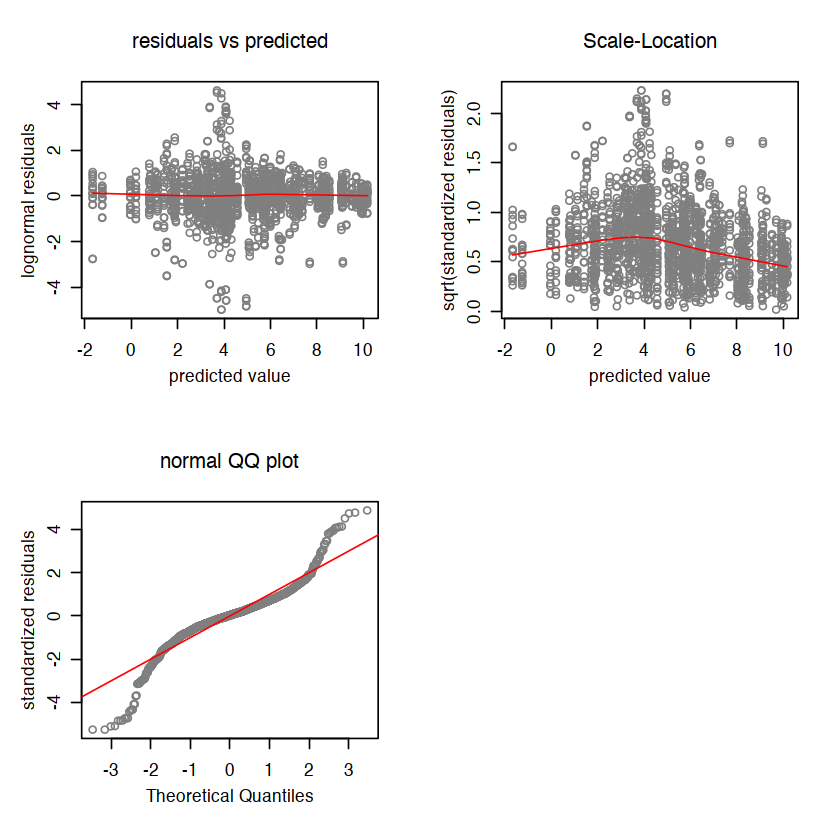

In [29]:
informed2=mcmc.qpcr(fixed="Tissue+Diet+Tissue:Diet",
                    random=c("Tank", "sample"),
                    data=dd2,
                    controls=c("EF1a",
                               "HPRT1",
                               "RPABC2"),
                    m.fix=1.2,
                    normalize=TRUE,
                    burnin=5000, # liability levels off at 5000 iterations
                    thin=20,
                    nitt=45000,
                    pr=T,
                    pl=T)
diagnostic.mcmc(model=informed2,
                col="grey50", 
                cex=0.8)

#### Remove outliers

In [30]:
outliers2 <- outlierSamples(informed2, dd2, z.cutoff = -2)
outliers2
ddNoOutliers2 <- dd2[!(dd2$sample %in% outliers2),]

[1] "Gut_T24_F1"  "Skin_T10_F3" "Skin_T22_F1"

$PRIOR
$PRIOR$R
$PRIOR$R$V
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
 [1,]    1    0    0    0    0    0    0    0    0
 [2,]    0    1    0    0    0    0    0    0    0
 [3,]    0    0    1    0    0    0    0    0    0
 [4,]    0    0    0    1    0    0    0    0    0
 [5,]    0    0    0    0    1    0    0    0    0
 [6,]    0    0    0    0    0    1    0    0    0
 [7,]    0    0    0    0    0    0    1    0    0
 [8,]    0    0    0    0    0    0    0    1    0
 [9,]    0    0    0    0    0    0    0    0    1

$PRIOR$R$nu
[1] 8.002


$PRIOR$G
$PRIOR$G$G1
$PRIOR$G$G1$V
[1] 1

$PRIOR$G$G1$nu
[1] 0


$PRIOR$G$G2
$PRIOR$G$G2$V
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
 [1,]    1    0    0    0    0    0    0    0    0
 [2,]    0    1    0    0    0    0    0    0    0
 [3,]    0    0    1    0    0    0    0    0    0
 [4,]    0    0    0    1    0    0    0    0    0
 [5,]    0    0    0    0    1    0    0    0    0
 [6,]    0    0    0    0    0    1    0 

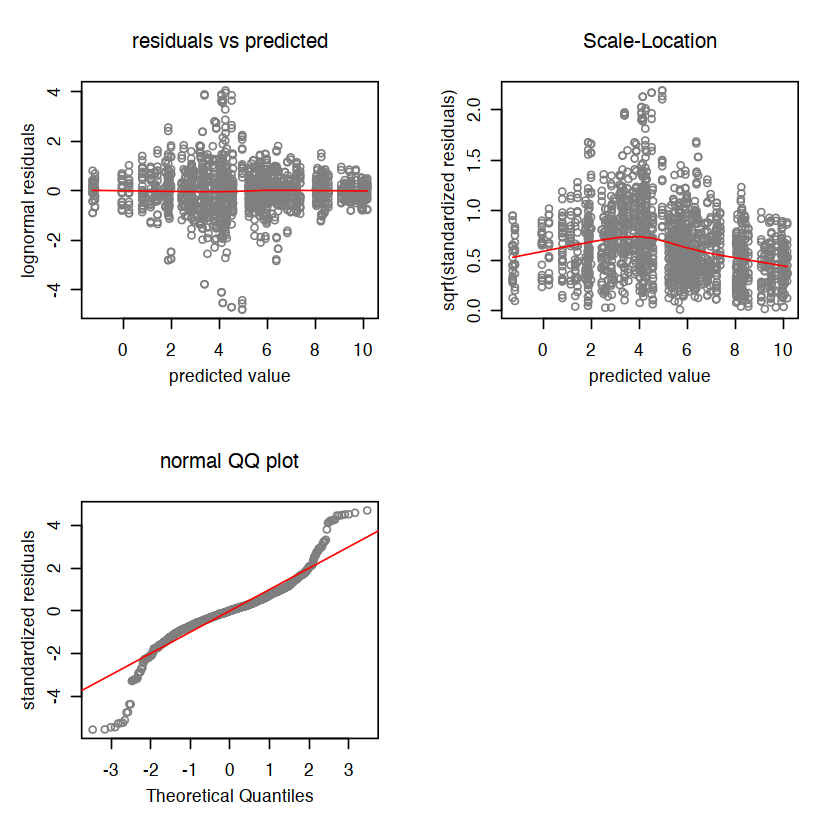

In [31]:
informedNO2 <- mcmc.qpcr(fixed="Tissue+Diet+Tissue:Diet",
                         random=c("Tank", "sample"),
                         data=ddNoOutliers2,
                         controls=c("EF1a",
                                    "HPRT1",
                                    "RPABC2"),
                         m.fix=1.2,
                         normalize=TRUE,
                         burnin=5000, # liability levels off at 5000 iterations
                         thin=20,
                         nitt=45000,
                         pr=T,
                         pl=T)
diagnostic.mcmc(model=informedNO2,
                col="grey50", 
                cex=0.8)

In [32]:
capture.output(summary(informedNO2), file = 'InnateGenes_StatsOutput.csv')

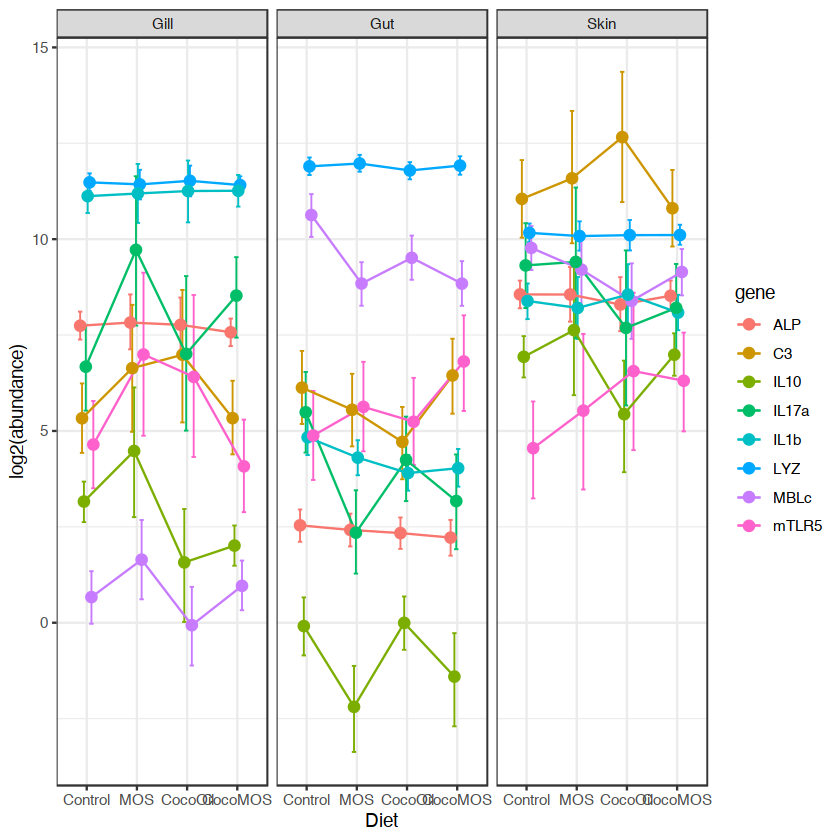

In [33]:
NCWMACsum2 <- HPDsummary(model=informedNO2,
                         ddNoOutliers2,
                         relative=F,
                         xgroup = 'Diet',
                         x.order=dietOrder,
                        )

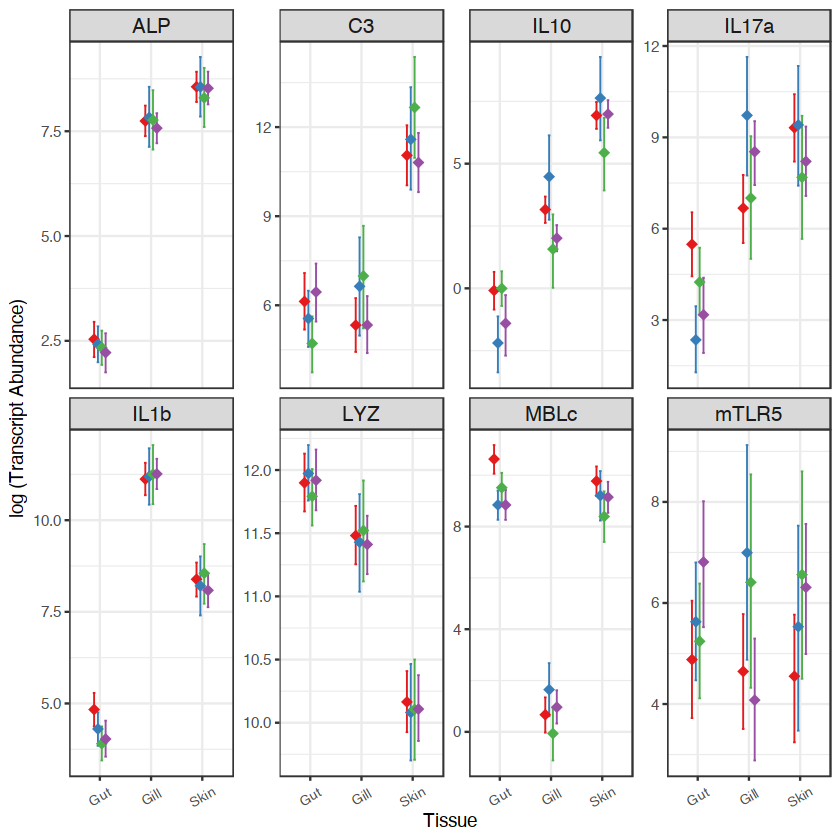

In [34]:
trellPlot2 <- trellisByGene(NCWMACsum2, xFactor="Tissue", groupFactor="Diet")
trellPlot2$data$Tissue <- factor(trellPlot2$data$Tissue, levels = c("Gut", "Gill", "Skin"))
trellPlot2$data$Diet <- factor(trellPlot2$data$Diet, levels = c("Control", "MOS", "CocoOil", "CocoMOS"))
trellPlot2NP <- remove_geom(trellPlot2, "GeomLine")
trellPlot2NP <- remove_geom(trellPlot2NP, "GeomPoint")
trellPlot2NP <- trellPlot2NP + geom_point(shape=18, size=3, position=position_dodge(width=.3))
trellPlot2NP <- trellPlot2NP + scale_color_brewer(palette = 'Set1', type='div'
                                                ) + theme(axis.text.x = element_text(size=8,
                                                                                     angle=30,
                                                                                     hjust = 0.5,
                                                                                     vjust = 0.5),
                                                          legend.position ='none'
                                                         )  + ylab('log (Transcript Abundance)')
trellPlot2NP 

In [35]:
data_text <- data.frame(label = c("-----------",
                                  "",
                                  "-----------",
                                  "",
                                  "-----------",
                                  "",
                                  "-----------",
                                  ""),
                        Diet = 'Control',
                        gene = c("ALP",
                                 "C3",
                                 "IL10",
                                 "IL17a",
                                 "IL1b",
                                 "LYZ",
                                 "MBLc",
                                 "mTLR5"),
                        yVal = c(5,
                                 9,
                                 6.5,
                                 12,
                                 7,
                                 9,
                                 5.75,
                                 2.5))
data_text2 <- data.frame(label = c("",
                                  "-----------",
                                  "-----------",
                                  "-----------",
                                  "-----------",
                                  "-----------",
                                  "-----------",
                                  ""),
                        Diet = 'Control',
                        gene = c("ALP",
                                 "C3",
                                 "IL10",
                                 "IL17a",
                                 "IL1b",
                                 "LYZ",
                                 "MBLc",
                                 "mTLR5"),
                        yVal = c(6,
                                 8.65,
                                 -3,
                                 3,
                                 9.2,
                                 10.6,
                                 4,
                                 2.5))
data_text3 <- data.frame(label = c("",
                                  "",
                                  "*",
                                  "*",
                                  "",
                                  "",
                                  "*",
                                  ""),
                        Diet = 'Control',
                        gene = c("ALP",
                                 "C3",
                                 "IL10",
                                 "IL17a",
                                 "IL1b",
                                 "LYZ",
                                 "MBLc",
                                 "mTLR5"),
                        yVal = c(6,
                                 9,
                                 2,
                                 7.5,
                                 9.5,
                                 10.75,
                                 3,
                                 2.5))
data_text4 <- data.frame(label = c("",
                                  "",
                                  "*",
                                  "",
                                  "",
                                  "",
                                  "",
                                  ""),
                        Diet = 'Control',
                        gene = c("ALP",
                                 "C3",
                                 "IL10",
                                 "IL17a",
                                 "IL1b",
                                 "LYZ",
                                 "MBLc",
                                 "mTLR5"),
                        yVal = c(6,
                                 9,
                                 -2.5,
                                 7.5,
                                 9.5,
                                 10.75,
                                 6.5,
                                 2.5))
data_text5 <- data.frame(label = c("",
                                  "",
                                  "*",
                                  "",
                                  "",
                                  "",
                                  "",
                                  ""),
                        Diet = 'Control',
                        gene = c("ALP",
                                 "C3",
                                 "IL10",
                                 "IL17a",
                                 "IL1b",
                                 "LYZ",
                                 "MBLc",
                                 "mTLR5"),
                        yVal = c(6,
                                 9,
                                 1,
                                 7.5,
                                 9.5,
                                 10.75,
                                 6.5,
                                 2.5))
data_text6 <- data.frame(label = c("----------------------",
                                   "----------------------",
                                   "----------------------",
                                   "----------------------",
                                   "----------------------",
                                   "----------------------",
                                   "",
                                   ""),
                         Diet = 'Control',
                         gene = c("ALP",
                                  "C3",
                                  "IL10",
                                  "IL17a",
                                  "IL1b",
                                  "LYZ",
                                  "MBLc",
                                  "mTLR5"),
                         yVal = c(6,
                                  13.7,
                                  8.6,
                                  11.5,
                                  6,
                                  9.25,
                                  9.5,
                                  2.5))

In [36]:
trellPlot2NPannot <- trellPlot2NP + geom_text(data = data_text,
                                              mapping = aes(x = 1.5,
                                                            y = yVal,
                                                            label = label),
                                              vjust = 0,
                                              color ='black',
                                              size=3) + geom_text(data = data_text2,
                                                                  mapping = aes(x = 2.5,
                                                                                y = yVal,
                                                                                label = label),
                                                                  vjust = 0,
                                                                  color ='black',
                                                                  size=3) + geom_text(data = data_text3,
                                                                                      mapping = aes(x = 1,
                                                                                                    y = yVal,
                                                                                                    label = label),
                                                                                      vjust = 0,
                                                                                      color ='black',
                                                                                      size=5) + geom_text(data = data_text4,
                                                                                                          mapping = aes(x = 2,
                                                                                                                        y = yVal,
                                                                                                                        label = label),
                                                                                                          vjust = 0,
                                                                                                          color ='black',
                                                                                                          size=5) + geom_text(data = data_text5,
                                                                                                                              mapping = aes(x = 3,
                                                                                                                                            y = yVal,
                                                                                                                                            label = label),
                                                                                                                                  vjust = 0,
                                                                                                                                  color ='black',
                                                                                                                                  size=5) + geom_text(data = data_text6,
                                                                                                                                                      mapping = aes(x = 2,
                                                                                                                                                                    y = yVal,
                                                                                                                                                                    label = label),
                                                                                                                                                          vjust = 0,
                                                                                                                                                          color ='black',
                                                                                                                                                          size=3)

## Get genewise stats

In [37]:
alp_Padj <- pSumFun2(NCWMACsum2$geneWise$ALP)
c3_Padj <- pSumFun2(NCWMACsum2$geneWise$C3)
il10_Padj <- pSumFun2(NCWMACsum2$geneWise$IL10)
il17a_Padj <- pSumFun2(NCWMACsum2$geneWise$IL17a)
il1b_Padj <- pSumFun2(NCWMACsum2$geneWise$IL1b)
lyz_Padj <- pSumFun2(NCWMACsum2$geneWise$LYZ)
mblc_Padj <- pSumFun2(NCWMACsum2$geneWise$MBLc)
mtlr5_Padj <- pSumFun2(NCWMACsum2$geneWise$mTLR5)

In [38]:
write.csv(alp_Padj, 'Stats/alpSigContrasts.csv')
write.csv(c3_Padj, 'Stats/C3SigContrasts.csv')
write.csv(il10_Padj, 'Stats/il10SigContrasts.csv')
write.csv(il17a_Padj, 'Stats/il17aSigContrasts.csv')
write.csv(il1b_Padj, 'Stats/il1bSigContrasts.csv')
write.csv(lyz_Padj, 'Stats/lyzSigContrasts.csv')
write.csv(mblc_Padj, 'Stats/mlbc2SigContrasts.csv')
write.csv(mtlr5_Padj, 'Stats/mtlr5SigContrasts.csv')

### Build multiplot of adaptive and innate

In [39]:
require(ggpubr)
trellPlots <- ggarrange(trellPlotNPannot, 
                        trellPlot2NPannot,
                        ncol=1,
                        common.legend = T,
                        legend='top', 
                        labels=c('A','B'))
ggsave(device='tiff','Adapt&InnateTissue_TrellisPlot.tiff')

Loading required package: ggpubr

Warning message:
“package ‘ggpubr’ was built under R version 4.0.2”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:ape’:

    rotate


Saving 7 x 7 in image



### Get normalized data for use with PCA or PCoA multivariate analysys

In [40]:
#nd=getNormalizedData(informedNO, data=ddNoOutliers, controls=c("EF1a","HPRT1","RPABC2"))
#saveRDS(nd,'normalizedAdaptGeneExp.RDS')
nd <- readRDS('normalizedAdaptGeneExp.RDS')

#nd2=getNormalizedData(informedNO2, data=ddNoOutliers2, controls=c("EF1a","HPRT1","RPABC2"))
#saveRDS(nd2,'normalizedInatGeneExp.RDS')
nd2 <- readRDS('normalizedInatGeneExp.RDS')

## Make PCoA plots of qPCR data using manhattan distance (sum of all log-fold-changes)

In [41]:
library(vegan)
library(ape) 

manND <- vegdist(nd$normData,method="manhattan", na.rm=TRUE)
mypcoa=pcoa(manND) 
scores=mypcoa$vectors
saveRDS(manND, 'Adaptive_ManhattanDist.RDS')

manND2 <- vegdist(nd2$normData,method="manhattan", na.rm=TRUE)
mypcoa2=pcoa(manND2) 
scores2=mypcoa2$vectors
saveRDS(manND2, 'Innate_ManhattanDist.RDS')

Warning message:
“package ‘vegan’ was built under R version 4.0.2”
Loading required package: permute

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.0.2”
This is vegan 2.5-7



In [42]:
nd$conditions$Diet <- factor(nd$conditions$Diet, levels=c('Control', 'MOS', 'CocoOil', 'CocoMOS'))
nd$conditions$Tissue <- factor(nd$conditions$Tissue, levels=c('Gut', 'Gill', 'Skin', 'PBL'))

nd2$conditions$Diet <- factor(nd2$conditions$Diet, levels=c('Control', 'MOS', 'CocoOil', 'CocoMOS'))
nd2$conditions$Tissue <- factor(nd2$conditions$Tissue, levels=c('Gut', 'Gill', 'Skin'))

In [43]:
col.rainbow <- c('brown3', 'deepskyblue4', 'chartreuse4', 'darkorchid') # match colors in other plots

In [44]:
tiff('PCR_PCoA.tiff', res=300, units='in', width=5, height=5)

par(mfrow=c(2,2), cex=0.9)

palette(col.rainbow)

par(mai=c(0.15,0.6,0.08,0.05))
p1 <- plot(
      scores[,1],scores[,2],
      col=as.numeric(as.factor(nd$conditions$Diet)),
      pch=as.numeric(as.factor(nd$conditions$Tissue))+14,
      ylab='', xlab='', xaxt='n')
p1 <- ordiellipse(scores,nd$conditions$Tissue, label=T, cex=0.6, draw='polygon')
legend('topright', 
       legend=c('Control', 'MOS', 'CocoOil', 'CocoMOS'), 
       col=1:4,
       pch=15,
       cex=0.55,
       title='Diet')

title(ylab="PC2", line=2, cex.lab=1)

#mai(B,L,T,R)
par(mai=c(0.15,0.6,0.08,0.05))
p3 <- plot(
      scores2[,1],scores2[,2],
      col=as.numeric(as.factor(nd2$conditions$Diet)),
      pch=as.numeric(as.factor(nd2$conditions$Tissue))+14,
      ylab='', xlab='', xaxt='n')
p3 <- ordiellipse(scores2,nd2$conditions$Tissue, label=T, cex=0.6, draw='polygon')

par(mai=c(0.8,0.6,0,0.05))
p2 <- plot(
      scores[,1],scores[,2],
      col=as.numeric(as.factor(nd$conditions$Diet)),
      pch=as.numeric(as.factor(nd$conditions$Tissue))+14,
      ylab='', xlab='')
p2 <- p2 + ordispider(scores,nd$conditions$Diet,label=T, cex=0.6) 
title(ylab="PC2", line=2, cex.lab=1)
title(xlab="PC1", line=2, cex.lab=1)

par(mai=c(0.8,0.6,0,0.05))
p4 <- plot(
      scores2[,1],scores2[,2],
      col=as.numeric(as.factor(nd2$conditions$Diet)),
      pch=as.numeric(as.factor(nd2$conditions$Tissue))+14,
      ylab='', xlab='')
p4 <- p4 + ordispider(scores2,nd2$conditions$Diet,label=T, cex=0.6) 
title(xlab="PC1", line=2, cex.lab=1)

text(grconvertX(.02, "ndc", "user"), grconvertY(.98, "ndc", "user"), "A", cex=1, col="black", font=2,xpd=NA)
text(grconvertX(.52, "ndc", "user"), grconvertY(.98, "ndc", "user"), "C", cex=1, col="black", font=2,xpd=NA)
text(grconvertX(.02, "ndc", "user"), grconvertY(.48, "ndc", "user"), "B", cex=1, col="black", font=2,xpd=NA)
text(grconvertX(.52, "ndc", "user"), grconvertY(.48, "ndc", "user"), "D", cex=1, col="black", font=2, xpd=NA)

dev.off()

pdf 
  2

## Multivariate analysis using permutational MANOVA

In [45]:
set.seed(1989)
permutest(betadisper(manND, nd$conditions$Diet))
permutest(betadisper(manND, nd$conditions$Tissue))
adonis2(manND ~ Diet*Tissue, data = nd$conditions, permutations = 999) #strata=Tank,

permutest(betadisper(manND2, nd2$conditions$Diet))
permutest(betadisper(manND2, nd2$conditions$Tissue))
adonis2(manND2 ~ Diet*Tissue, data = nd2$conditions, permutations = 999) #strata=Tank,


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq Mean Sq     F N.Perm Pr(>F)
Groups      3   15.38  5.1276 0.293    999  0.838
Residuals 136 2380.16 17.5012                    

Warning message in betadisper(manND, nd$conditions$Tissue):
“some squared distances are negative and changed to zero”



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq     F N.Perm Pr(>F)
Groups      3  22.29  7.4309 1.936    999  0.117
Residuals 136 521.99  3.8382                    

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,345.1362,0.01972752,6.374835,0.001
Tissue,3,14288.8070,0.81672887,263.921275,0.001
Diet:Tissue,9,623.4189,0.03563378,3.838284,0.001
Residual,124,2237.8038,0.12790983,NA,NA
Total,139,17495.1659,1.00000000,NA,NA



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq Mean Sq     F N.Perm Pr(>F)
Groups      3   88.37  29.457 0.942    999  0.461
Residuals 101 3158.47  31.272                    

Warning message in betadisper(manND2, nd2$conditions$Tissue):
“some squared distances are negative and changed to zero”



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      2  406.1 203.050 18.795    999  0.001 ***
Residuals 102 1101.9  10.803                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,282.2314,0.007962077,2.479061,0.032
Tissue,2,30549.2802,0.861830756,402.507605,0.001
Diet:Tissue,6,1086.2192,0.030643507,4.770559,0.001
Residual,93,3529.2290,0.099563660,NA,NA
Total,104,35446.9598,1.000000000,NA,NA


In [46]:
require('RVAideMemoire')
pairwise.perm.manova(manND, nd$conditions$Diet)
pairwise.perm.manova(manND, nd$conditions$Tissue)

pairwise.perm.manova(manND2, nd2$conditions$Diet)
pairwise.perm.manova(manND2, nd2$conditions$Tissue)

Loading required package: RVAideMemoire

Warning message:
“package ‘RVAideMemoire’ was built under R version 4.0.2”
*** Package RVAideMemoire v 0.9-80 ***




	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  manND by nd$conditions$Diet
999 permutations 

        Control MOS  CocoOil
MOS     0.77    -    -      
CocoOil 0.77    0.77 -      
CocoMOS 0.77    0.57 0.57   

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  manND by nd$conditions$Tissue
999 permutations 

     Gut   Gill  Skin 
Gill 0.001 -     -    
Skin 0.001 0.001 -    
PBL  0.001 0.001 0.001

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  manND2 by nd2$conditions$Diet
999 permutations 

        Control MOS  CocoOil
MOS     0.97    -    -      
CocoOil 0.97    0.97 -      
CocoMOS 0.97    0.97 0.97   

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  manND2 by nd2$conditions$Tissue
999 permutations 

     Gut   Gill 
Gill 0.001 -    
Skin 0.001 0.001

P value adjustment method: fdr 

### Arrange data for PCA analysis - set all negative expression estimates to zero

In [47]:
nd$normData$Individual <- row.names(nd$normData)
ndOut <- inner_join(nd$normData, nd$conditions)
ndOut[1:7][ndOut[1:7]<0] <- 0
ndOut[1:7][is.na(ndOut[1:7])] <- 0
ndOut$Tissue <- factor(ndOut$Tissue, levels=c('Gill','Gut', 'Skin', 'PBL'))
ndOut$Diet <- factor(ndOut$Diet, levels=c('Control', 'MOS', 'CocoOil', 'CocoMOS'))
head(ndOut)


nd2$normData$Individual <- row.names(nd2$normData)
nd2Out <- inner_join(nd2$normData, nd2$conditions)
nd2Out[1:8][nd2Out[1:8]<0] <- 0
nd2Out[1:8][is.na(nd2Out[1:8])] <- 0
nd2Out$Tissue <- factor(nd2Out$Tissue, levels=c('Gill','Gut', 'Skin', 'PBL'))
nd2Out$Diet <- factor(nd2Out$Diet, levels=c('Control', 'MOS', 'CocoOil', 'CocoMOS'))
head(nd2Out)

Joining, by = "Individual"



,CD8a,CD4,FOXP3,IgM,IgT,MHC1,MHC2,Individual,Tank,Diet,Tissue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>
1,10.19013,11.32933,5.319644,12.30675,8.603234,20.01186,19.04528,Gut_T10_F1,T10,Control,Gut
2,10.78567,10.66598,4.359760,12.29095,12.980167,20.27774,18.60511,Gut_T18_F2,T18,Control,Gut
3,10.48347,10.77809,4.820506,14.84727,10.501354,20.23453,18.43614,Gut_T10_F2,T10,Control,Gut
4,10.80837,10.90499,5.131325,13.02574,10.023816,19.55461,18.43811,Gut_T18_F3,T18,Control,Gut
5,10.44039,10.74859,6.130449,12.83272,9.374006,19.98835,18.32275,Gut_T10_F3,T10,Control,Gut
6,11.08027,10.66496,5.439148,10.91713,8.900851,19.72019,18.62156,Gut_T17_F1,T17,Control,Gut


Joining, by = "Individual"



,ALP,LYZ,C3,MBLc,IL1b,IL10,IL17a,mTLR5,Individual,Tank,Diet,Tissue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>
1,2.445843,11.93499,5.723187,10.048779,4.315948,0.0000000,4.583678,2.880137,Gut_T10_F1,T10,Control,Gut
2,2.480370,11.91941,4.583180,9.717996,3.926076,0.0000000,4.969597,0.000000,Gut_T18_F2,T18,Control,Gut
3,3.081225,11.91997,7.754342,10.969605,4.825876,0.0000000,3.466191,5.936908,Gut_T10_F2,T10,Control,Gut
4,2.279297,11.90875,5.038636,10.629279,4.092899,0.0000000,6.287131,5.527145,Gut_T18_F3,T18,Control,Gut
5,2.450415,11.90352,7.038948,11.263921,5.264832,0.4347625,6.900020,5.143218,Gut_T10_F3,T10,Control,Gut
6,2.491322,11.86749,4.036921,11.060524,4.747863,0.1260442,6.974395,5.024942,Gut_T17_F1,T17,Control,Gut


Warning message:
“package ‘ggfortify’ was built under R version 4.0.2”
Warning message:
“Removed 1 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Saving 7 x 7 in image



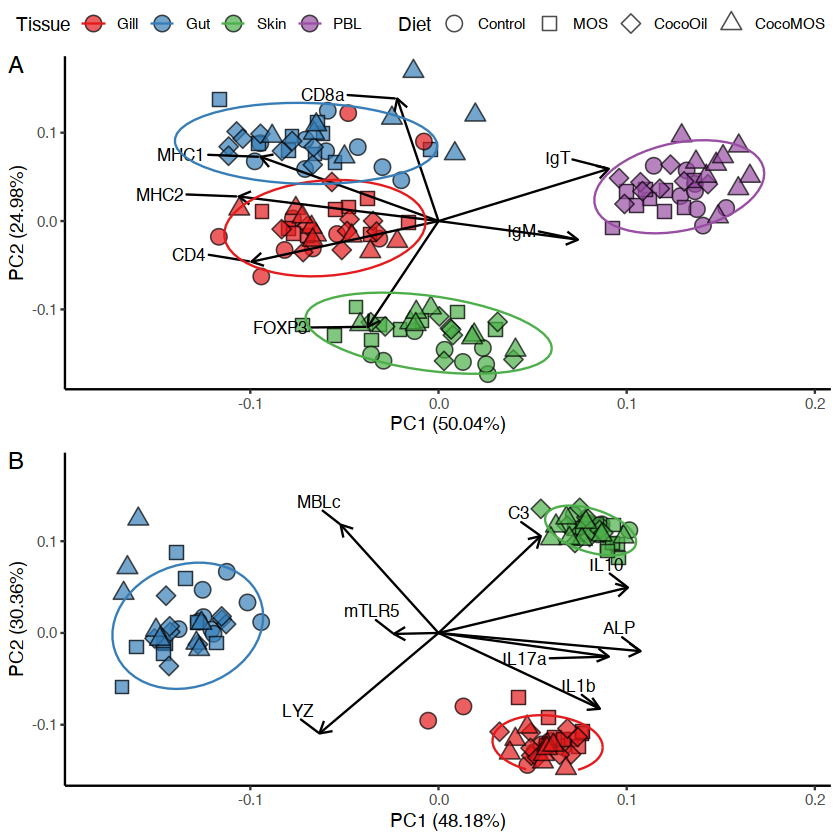

In [48]:
library(ggfortify)
set.seed(123)
adPCA <- prcomp(ndOut[1:7], scale=TRUE)
adPCAplot <- autoplot(adPCA, 
                      data=ndOut, 
                      fill='Tissue', 
                      shape='Diet', 
                      size=4,
                      alpha=0.7,
                      loadings = TRUE, 
                      loadings.colour = 'black',
                      loadings.label = TRUE,
                      loadings.label.colour = 'black',
                      loadings.label.repel = TRUE,
                      #loadings.label.fontface = 'bold',
                      loadings.label.size = 3.5,
                      loadings.label.hjust=0.1,
                      loadings.label.vjust=-0.2
                     ) + scale_shape_manual(values=c(21, 22, 23, 24)
                                           ) + guides(fill=guide_legend(override.aes=list(shape=21))
                                                     ) + scale_fill_brewer(palette='Set1'
                                                                          ) + stat_ellipse(aes(color=Tissue)
                                                                                          ) + scale_color_brewer(palette='Set1'
                                                                                                                ) + xlim(c(-0.18,0.19)
                                                                                                                        ) + theme_classic()

inPCA <- prcomp(nd2Out[1:8], scale=TRUE)
inPCAplot <- autoplot(inPCA, 
         data=nd2Out, 
         fill='Tissue', 
         shape='Diet', 
         size=4,
         alpha=0.7,
         loadings = TRUE, 
         loadings.colour = 'black',
         loadings.label = TRUE,
         loadings.label.colour = 'black',
         loadings.label.repel = TRUE,
         #loadings.label.fontface = 'bold',
         loadings.label.size = 3.5,            
         loadings.label.hjust=-0.4,
         loadings.label.vjust=-0.4) + scale_shape_manual(values=c(21, 22, 23, 24)
                                                        ) + guides(fill=guide_legend(override.aes=list(shape=21))
                                                                  ) + scale_fill_brewer(palette='Set1'
                                                                                       ) + stat_ellipse(aes(color=Tissue)
                                                                                                       ) + scale_color_brewer(palette='Set1'
                                                                                                                             ) + xlim(c(-0.18,0.19)
                                                                                                                                     ) + ylim(c(-0.15,0.18)
                                                                                                                                             ) + theme_classic()

saveRDS(adPCAplot, '../MicroAnalysis/NCWMAC_Micro/Figures/Manuscript/PCRadPCA.RDS')
saveRDS(inPCAplot, '../MicroAnalysis/NCWMAC_Micro/Figures/Manuscript/PCRinPCA.RDS')

ggarrange(adPCAplot, inPCAplot, common.legend=TRUE, ncol=1,labels="AUTO", legend='top')
ggsave('qPCR_PCAplots.tiff', bg='white')

Warning message:
“Removed 1 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


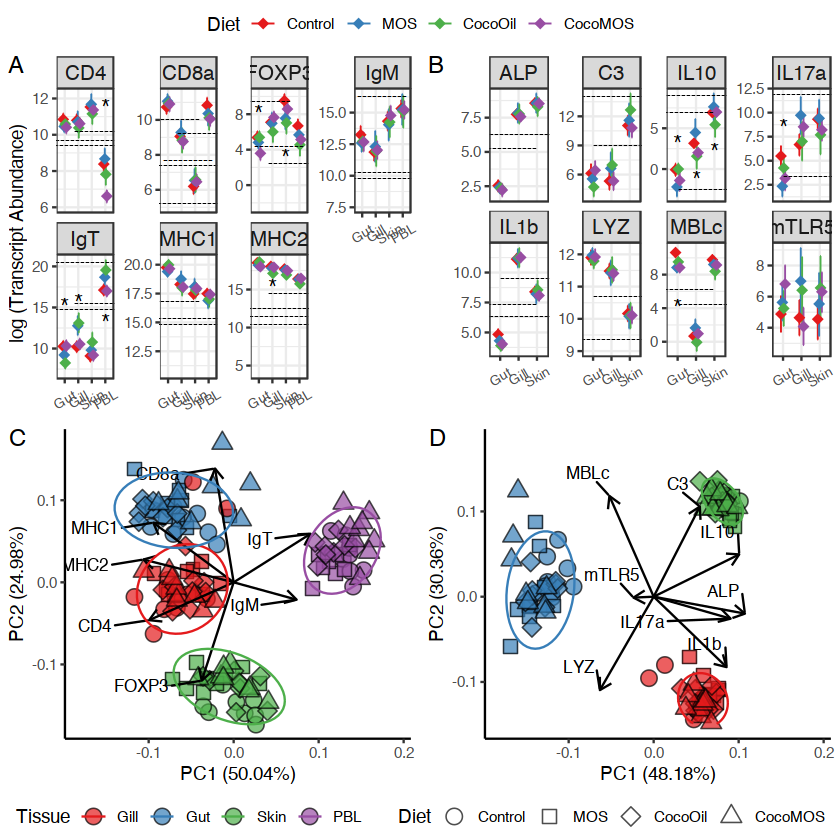

In [75]:
trellPlots <- ggarrange(trellPlotNPannot, 
                        trellPlot2NPannot + ylab('') + xlab(''),
                        ncol=2,
                        common.legend = T,
                        legend='top',
                        labels=c('A','B'))
PCAplots <- ggarrange(adPCAplot,
                      inPCAplot,
                      common.legend=TRUE,
                      ncol=2,
                      labels=c('C', 'D'),
                      legend='bottom')
ggarrange(trellPlots, PCAplots, nrow=2)
ggsave('../MicroAnalysis/NCWMAC_Micro/Figures/Manuscript/GEmultiplot.png', width=10, height=10, bg='white')

## Analyze Gut only genes - not included in publication

In [50]:
NCWMAC.res3 <- read.csv("NCWMACqPCR_GutOnlyGenes.csv")

In [51]:
head(NCWMAC.res3)
levels(NCWMAC.res3$Diet)
levels(NCWMAC.res3$Tissue)

,sample,Individual,Tank,Diet,Tissue,EF1a,HPRT1,RPABC2,SAA5,MUC2
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.50941,21.95600,23.13333,30.33865,19.17161
2,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.42801,21.92615,23.01739,29.98343,18.93409
3,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.55006,22.26392,24.78876,35.03577,20.45091
4,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.41079,22.34390,24.76378,35.99656,20.45575
5,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.51326,21.80875,23.91790,25.51175,19.01351
6,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.43221,21.55769,23.70948,25.30201,18.92074


NULL

NULL

In [52]:
NCWMAC.res3$Diet <- factor(NCWMAC.res3$Diet , levels = c("Control", "MOS", "CocoOil", "CocoMOS"))

In [53]:
head(NCWMAC.res3)
levels(NCWMAC.res3$Diet)
levels(NCWMAC.res3$Tissue)

,sample,Individual,Tank,Diet,Tissue,EF1a,HPRT1,RPABC2,SAA5,MUC2
,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.50941,21.95600,23.13333,30.33865,19.17161
2,Gut_T10_F1,Gut_T10_F1,T10,Control,Gut,20.42801,21.92615,23.01739,29.98343,18.93409
3,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.55006,22.26392,24.78876,35.03577,20.45091
4,Gut_T18_F2,Gut_T18_F2,T18,Control,Gut,22.41079,22.34390,24.76378,35.99656,20.45575
5,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.51326,21.80875,23.91790,25.51175,19.01351
6,Gut_T10_F2,Gut_T10_F2,T10,Control,Gut,21.43221,21.55769,23.70948,25.30201,18.92074


[1] "Control" "MOS"     "CocoOil" "CocoMOS"

NULL

In [54]:
dd3=cq2counts(data=NCWMAC.res3, 
              genecols=c(6:10),# adjust 
              condcols=c(1:5),#adjust
              effic=NCWMAC.eff, 
              Cq1=37)

$PRIOR
$PRIOR$R
$PRIOR$R$V
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

$PRIOR$R$nu
[1] 2.002


$PRIOR$G
$PRIOR$G$G1
$PRIOR$G$G1$V
[1] 1

$PRIOR$G$G1$nu
[1] 0


$PRIOR$G$G2
$PRIOR$G$G2$V
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

$PRIOR$G$G2$nu
[1] 0


$PRIOR$G$G3
$PRIOR$G$G3$V
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

$PRIOR$G$G3$nu
[1] 0




$FIXED
[1] "count~gene+Diet+gene:Diet"

$RANDOM
[1] "~sample+idh(gene):Tank+idh(gene):sample"


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000139

 Acceptance ratio for liability set 2 = 0.000389

 Acceptance ratio for liability set 3 = 0.000278

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.089153

 Acceptance ratio for liability set 2 = 0.257556

 Acceptance ratio for liability set 3 = 0.046819

                       MCMC iteration = 2000

 Acceptanc

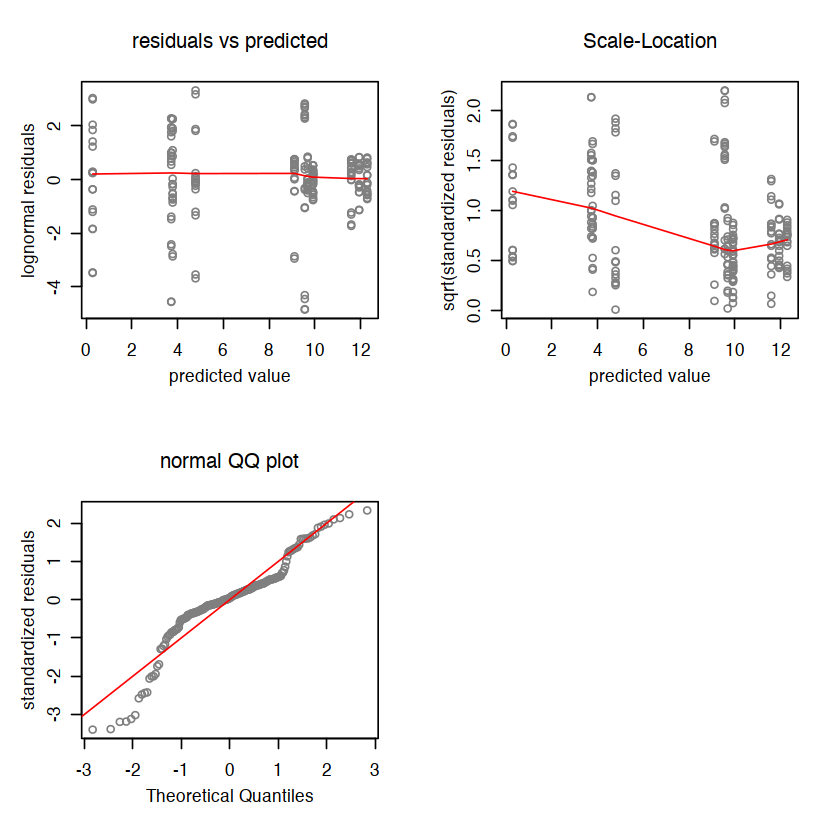

In [55]:
informed3=mcmc.qpcr(fixed="Diet",
                    random=c("Tank", "sample"),
                    data=dd3,
                    controls=c("EF1a",
                               "HPRT1",
                               "RPABC2"),
                    m.fix=1.2,
                    normalize=TRUE,
                    burnin=5000, # liability levels off at 5000 iterations
                    thin=20,
                    nitt=45000,
                    pr=T,
                    pl=T)

diagnostic.mcmc(model=informed3,
                col="grey50", 
                cex=0.8)

In [56]:
outliers3 <- outlierSamples(informed3, dd3, z.cutoff = -2)
outliers3
ddNoOutliers3 <- dd3[!(dd3$sample %in% outliers3),]

[1] "Gut_T24_F1"

$PRIOR
$PRIOR$R
$PRIOR$R$V
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

$PRIOR$R$nu
[1] 2.002


$PRIOR$G
$PRIOR$G$G1
$PRIOR$G$G1$V
[1] 1

$PRIOR$G$G1$nu
[1] 0


$PRIOR$G$G2
$PRIOR$G$G2$V
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

$PRIOR$G$G2$nu
[1] 0


$PRIOR$G$G3
$PRIOR$G$G3$V
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

$PRIOR$G$G3$nu
[1] 0




$FIXED
[1] "count~gene+Diet+gene:Diet"

$RANDOM
[1] "~sample+idh(gene):Tank+idh(gene):sample"


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000171

 Acceptance ratio for liability set 2 = 0.000314

 Acceptance ratio for liability set 3 = 0.000286

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.086671

 Acceptance ratio for liability set 2 = 0.260000

 Acceptance ratio for liability set 3 = 0.040429

                       MCMC iteration = 2000

 Acceptanc

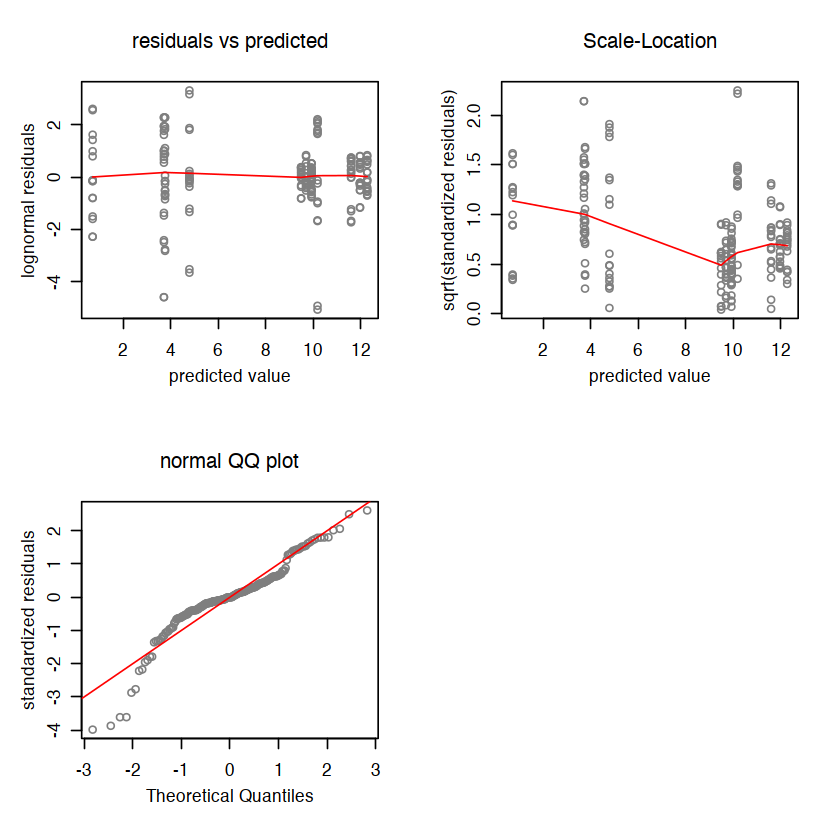

In [57]:
informedNO3=mcmc.qpcr(fixed="Diet",
                      random=c("Tank", "sample"),
                      data=ddNoOutliers3,
                      controls=c("EF1a",
                                 "HPRT1",
                                 "RPABC2"),
                      m.fix=1.2,
                      normalize=TRUE,
                      burnin=5000, # liability levels off at 5000 iterations
                      thin=20,
                      nitt=45000,
                      pr=T,
                      pl=T)
diagnostic.mcmc(model=informedNO3,
                col="grey50", 
                cex=0.8)

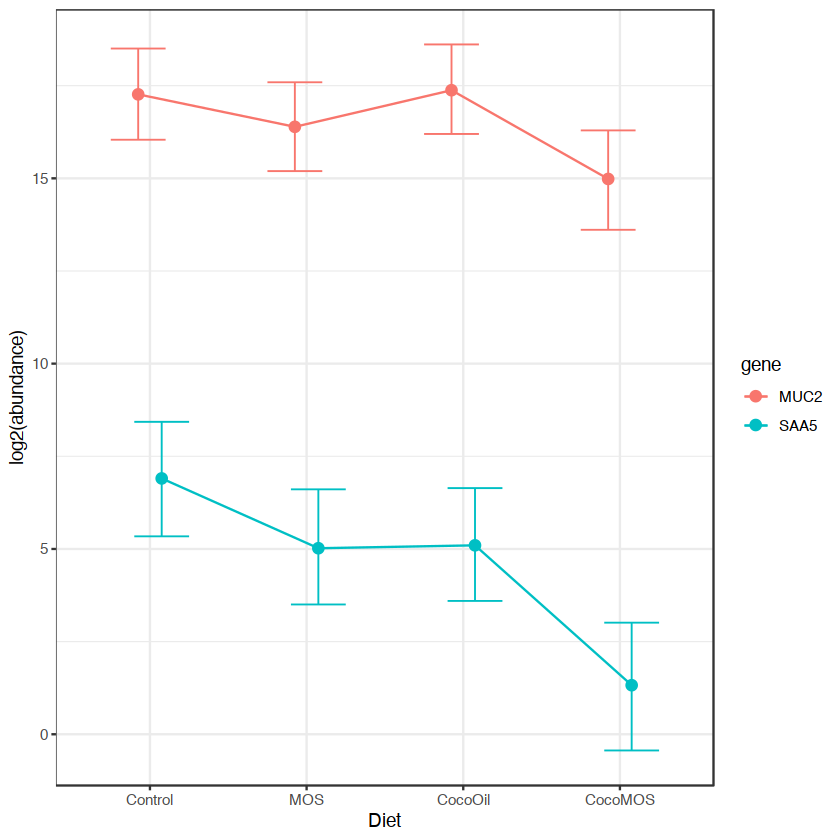

In [58]:
NCWMACsum3 <- HPDsummary(model=informedNO3,
                        ddNoOutliers3,
                        relative=F,
                        xgroup = 'Diet',
                        x.order=dietOrder)

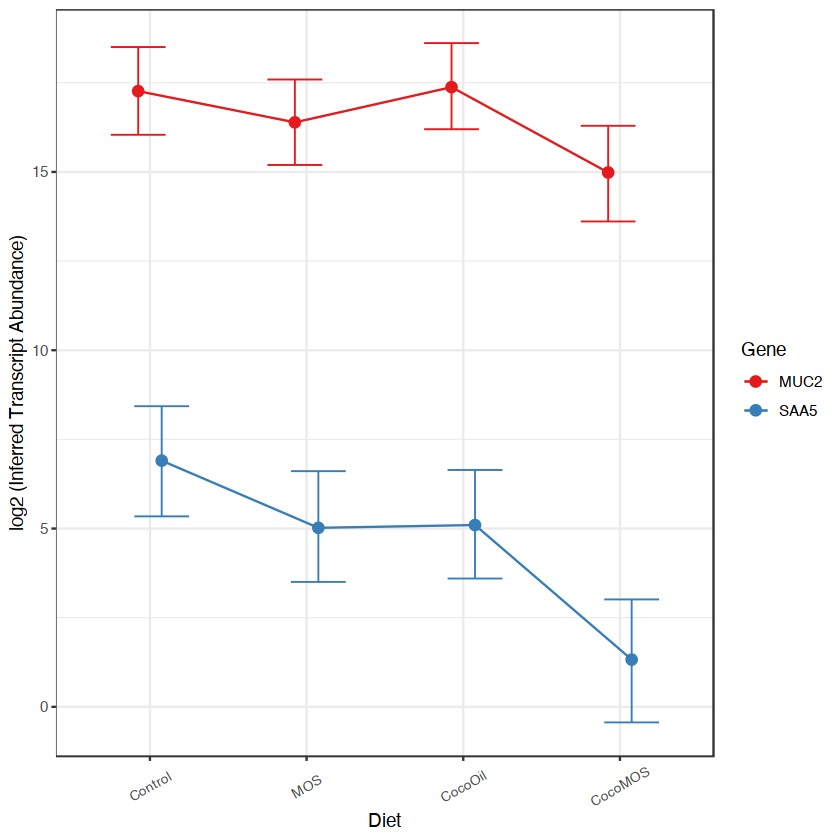

In [59]:
NCWMACsum3$ggPlot$labels$colour <- 'Gene'
NCWMACsum3$ggPlot + ylab('log2 (Inferred Transcript Abundance)'
                         ) + scale_color_brewer(palette = 'Set1'
                                              )+ theme(axis.text.x = element_text(size=8,
                                                                                  angle=30,
                                                                                  hjust = 0.5,
                                                                                  vjust = 0.5))

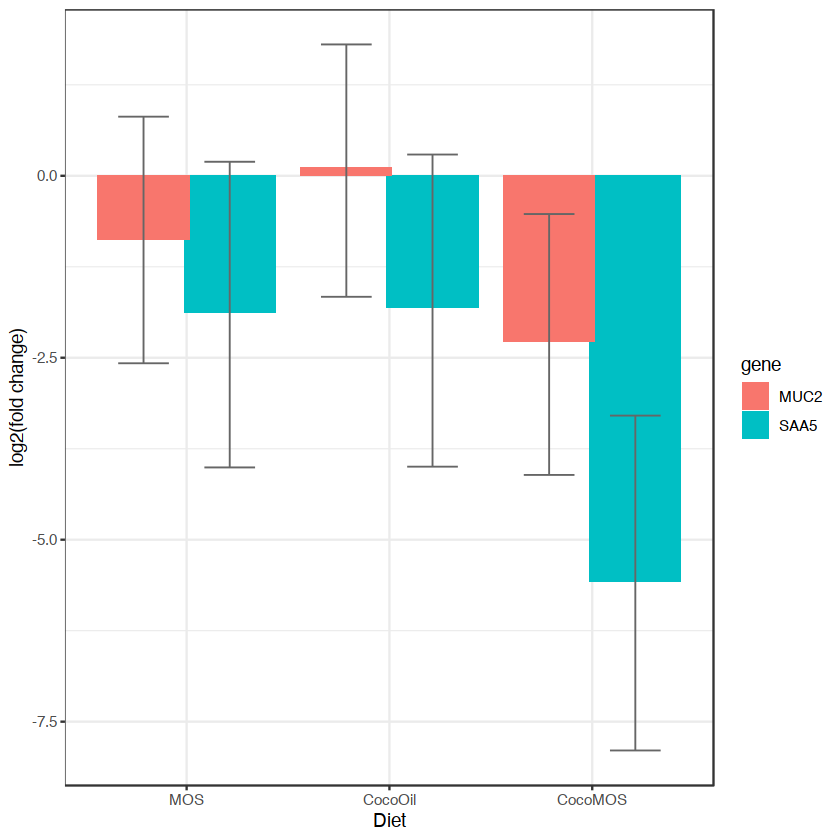

In [60]:
NCWMACsum3R <- HPDsummary(model=informedNO3,
                        ddNoOutliers3,
                        relative=T,
                        xgroup = 'Diet',
                        x.order=dietOrder)

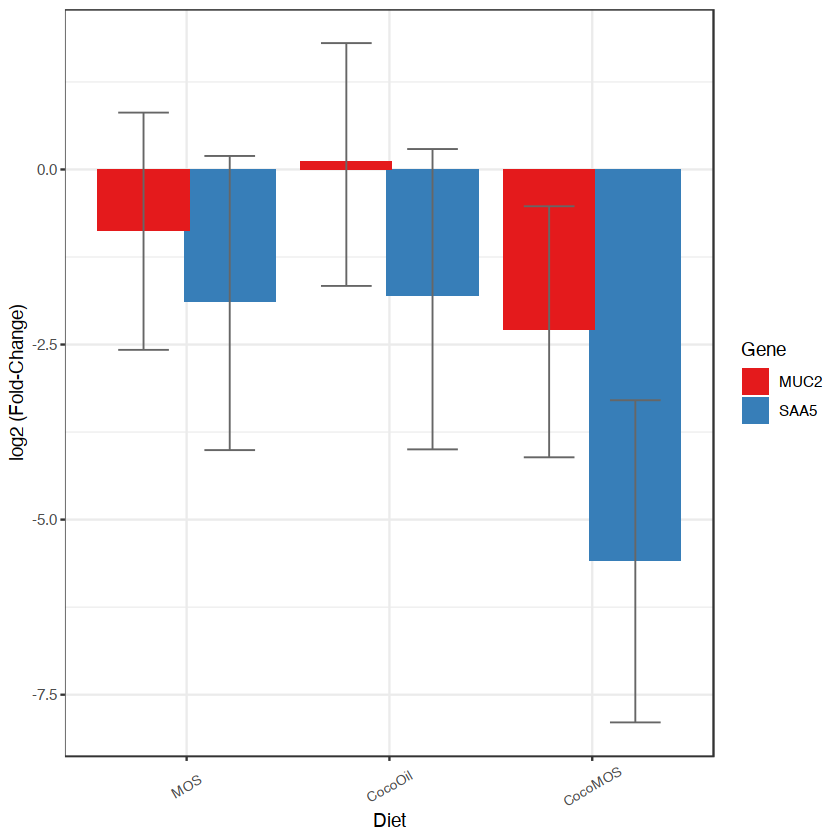

In [61]:
NCWMACsum3R$ggPlot$labels$fill <- 'Gene'
NCWMACsum3R$ggPlot + ylab('log2 (Fold-Change)'
                         ) + scale_fill_brewer(palette = 'Set1'
                                              ) + theme(axis.text.x = element_text(size=8,
                                                                                   angle=30,
                                                                                   hjust = 0.5,
                                                                                   vjust = 0.5))